### Data Loading

This part is same as the code in Data_Cleaning_Fayeh

In [19]:
# import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import torch
import torch.utils.data as d
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

/var/folders/1k/nx71_3fn3258zqsq8yky0fp46_qmw5/T/ipykernel_89423/611486857.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [7]:
# create data directories
dataset_dir='/home/coder/workspace/UCI HAR Dataset'
signal_class = [
        'body_acc_x_',
        'body_acc_y_',
        'body_acc_z_',
        'body_gyro_x_',
        'body_gyro_y_',
        'body_gyro_z_',
        'total_acc_x_',
        'total_acc_y_',
        'total_acc_z_']
X_train_path = [dataset_dir + '/train/Inertial Signals/' + signal + 'train.txt' for signal in signal_class]
X_test_path = [dataset_dir + '/test/Inertial Signals/' + signal + 'test.txt' for signal in signal_class]
Y_train_path = dataset_dir + '/train/y_train.txt'
Y_test_path = dataset_dir + '/test/y_test.txt'

In [8]:
# what are the activity labels (substract 1 to each output class for friendly 0-based indexing)
activity = {
        0: 'Walking',
        1: 'Walking Upstairs',
        2: 'Walking Downstairs',
        3: 'Sitting',
        4: 'Standing',
        5: 'Laying'}

In [140]:
class Data(d.Dataset):
    def __init__(self, X_filepath: list, Y_filepath: str):
        """
        We initialize the directory containing the training and test file. 
        For example, one of my local file path for X_filepath is '/Users/zliu/Downloads/HAR_Data/UCI_HAR_Dataset/train/Inertial_Signals/body_acc_x_train.txt'
        
        """
        self.X_filepath = X_filepath
        self.Y_filepath = Y_filepath

    def load_data(self):
        """
        We load data from file paths and return X_data and Y_data.
        
        """
        
        print("Loading Data from following directories:")
        print("\n")
        [print(p + "\n") for p in self.X_filepath]
        print(self.Y_filepath)    
        
        def xload(X_path):
            x = []
            for each in X_path:
                with open(each, 'r') as f:
                    x.append(np.array([eachline.replace('  ', ' ').strip().split(' ') for eachline in f], dtype=np.float32))
            x = np.transpose(x, (1, 2, 0))
            return x

        def yload(Y_path):
            y = pd.read_csv(Y_path, header=None).to_numpy().reshape(-1)
            
            # Substract 1 to each output class for friendly 0-based indexing
            return y - 1  

        X_data = xload(self.X_filepath)
        Y_data = yload(self.Y_filepath)
        
        print("\nFinish Data Load")
        
        return X_data, Y_data
        
        
    def load_data_torch(self, X_data, Y_data):
        """
        Load data into torch tensor.
        """
    
        torch_data = d.TensorDataset(torch.from_numpy(X_data).float().unsqueeze(1), torch.from_numpy(Y_data).long())
        
        return torch_data

In [10]:
# Load the data from file paths
data_train = Data(X_train_path, Y_train_path)
X_train, Y_train = data_train.load_data()

data_test = Data(X_test_path, Y_test_path)
X_test, Y_test = data_test.load_data()

Loading Data from following directories:


/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt

/home/coder/workspace/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt

/home/coder/workspace/UCI HAR Dataset/train/y_train.txt

Finish Data Load
Loading Data from following directories:


/home/coder/workspace/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt

/home/

In [141]:
# Load the data into torch tensors
data_train = Data(X_train_path, Y_train_path)
data_train_tensor = data_train.load_data_torch(X_train, Y_train)

data_test = Data(X_test_path, Y_test_path)
data_test_tensor = data_test.load_data_torch(X_test, Y_test)

In [60]:
category = len(set(Y_test.tolist()))

In [137]:
train_loader = d.DataLoader(dataset = data_train_tensor, batch_size = 128,
                               shuffle = True, num_workers = 4)
test_loader = d.DataLoader(dataset = data_test_tensor, batch_size = 128,
                               shuffle = True, num_workers = 4)

### Build a CNN Model

Note that in this pratice I did not standardize the data because the CNN model performance was better when I train the model with raw data. Instead, we use batch normalization to standardize data during training.

#### How to define the Model Architecture?

- Conv2d Layers
    - Our in channel is 1 since each observation has a (9*128) matrix as feature. It's different from image processing where there are three color channels (RGB) where in channel is 3.
    - We use a kernel as (3, 1) which will move over the whole feature matrix. We use a stride of (2,1) and padding as (1,0).
    
- Batch Normalization
    - It starts off by z-score normalizing all data points in the batch training data. Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift) and therefore speed up training.
    
- ReLU Activation
    - It's a popular activation function to overcome the vanishing gradients problems.
    
- Adaptive Average Pooling
    - A 2-D adaptive average pooling layer performs downsampling to give us the desired output size by dividing the input into rectangular pooling regions, then computing the average of each region.


In [144]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, train_shape, category):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1, 64, (3, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, (3, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, (3, 1), (2, 1), (1, 0)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.ada_pool = nn.AdaptiveAvgPool2d((1, train_shape[-1]))
        self.fc = nn.Linear(512*train_shape[-1], category)
        
    def forward(self, x):
        '''
            x.shape: [b, c, series, modal]
        '''
        x = self.layer(x)
        x = self.ada_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [145]:
# We ran a few rounds of hyperparameter tuning, and let the CNN train with a learning rate of 0.0005 and run 20 epochs.

from torch.cuda.amp import GradScaler, autocast
LR = 0.0005
num_epochs = 20
net = CNN(X_train.shape, category)
optimizer = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=0.001)
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//3, 0.5)
loss_fn = nn.CrossEntropyLoss()
scaler = GradScaler() 
print('\n==================================================   Training   ===================================================\n')
acc_train, loss_train, acc_val, loss_val = [], [], [], []
best_accr, early_stop, steps = 0, 0, 0
for i in range(num_epochs):
    
    ############### Training ###############
    # Initialize
    net.train()
    cor = 0
    loss_tmp, loss_cnt, acc_tmp = 0, 0, 0
    
    for data, label in train_loader:
        data, label = data, label
        
        with autocast():
            out = net(data)
            loss = loss_fn(out, label)
        _, pre = torch.max(out, 1)
        cor += (pre == label).sum()
        
        # training loss
        loss_tmp += loss.item()
        loss_cnt += 1
        
        optimizer.zero_grad() 
        scaler.scale(loss).backward() 
        scaler.step(optimizer) 
        scaler.update() 
    acc_tmp = cor.item()/len(Y_train)
    lr_sch.step()
    
    ############### Evaluation ###############
    net.eval()
    loss_train.append(loss_tmp/loss_cnt)
    acc_train.append(acc_tmp)
    loss_tmp, loss_cnt, acc_tmp = 0,0, 0
    cor = 0
    for data, label in test_loader:
        data, label = data, label
        with autocast():
            out = net(data)
            loss = loss_fn(out, label)
        _, pre = torch.max(out, 1)
        cor += (pre == label).sum()
        
        # validation loss
        loss_tmp += loss.item()
        loss_cnt += 1
    acc_tmp = cor.item()/len(Y_test)
    loss_val.append(loss_tmp/loss_cnt)
    acc_val.append(acc_tmp)
    print('epoch: %d, train-loss: %f, val-acc: %f' % (i, loss_train[-1], acc_val[-1]))


==================================================   Training   ===================================================



python(66323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 0, train-loss: 0.111865, val-acc: 0.846624


python(67107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 1, train-loss: 0.151138, val-acc: 0.914150


python(68400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 2, train-loss: 0.081132, val-acc: 0.931456


python(69521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 3, train-loss: 0.082117, val-acc: 0.929420


python(70432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 4, train-loss: 0.054273, val-acc: 0.906345


python(71469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 5, train-loss: 0.098642, val-acc: 0.933831


python(72584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 6, train-loss: 0.109948, val-acc: 0.939260


python(73747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 7, train-loss: 0.070837, val-acc: 0.941636


python(75688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(75691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 8, train-loss: 0.063523, val-acc: 0.948761


python(77005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 9, train-loss: 0.048786, val-acc: 0.950119


python(79896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 10, train-loss: 0.110658, val-acc: 0.952833


python(80813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 11, train-loss: 0.020160, val-acc: 0.949779


python(82179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 12, train-loss: 0.007592, val-acc: 0.958941


python(83325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(83982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 13, train-loss: 0.056895, val-acc: 0.956566


python(84106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 14, train-loss: 0.018492, val-acc: 0.960299


python(84937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85728) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 15, train-loss: 0.046610, val-acc: 0.958263


python(85871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 16, train-loss: 0.011009, val-acc: 0.951137


python(86868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 17, train-loss: 0.039628, val-acc: 0.952155


python(88036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88749) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88752) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 18, train-loss: 0.021581, val-acc: 0.959281


python(88878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


epoch: 19, train-loss: 0.009416, val-acc: 0.958941


Let's plot the training and validation loss and accuracy over time.

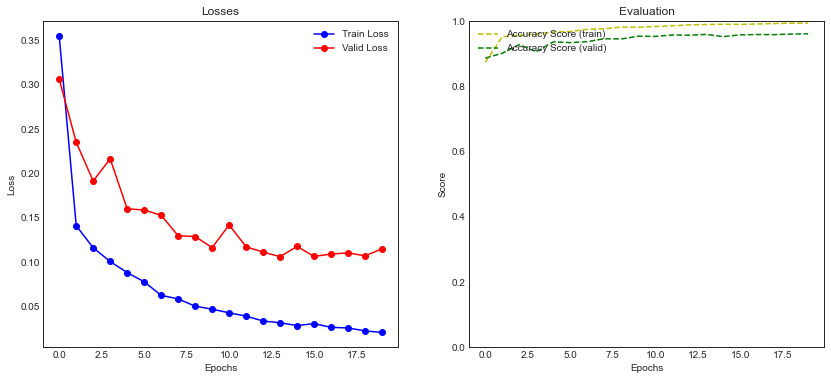

In [316]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title("Losses")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.plot(loss_train, 'b-o', label='Train Loss')
ax1.plot(loss_val, 'r-o', label='Valid Loss')
ax1.legend(loc="upper right")
        
ax2.set_title("Evaluation")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Score")
ax2.set_ylim(0,1)
ax2.plot(acc_train, 'y--', label='Accuracy Score (train)')
ax2.plot(acc_val, 'g--', label='Accuracy Score (valid)')
ax2.legend(loc="upper left")

plt.show()

In [302]:
# Gather the F1 (Macro) Evaluation Metrics
from sklearn.metrics import f1_score
net.eval()
cor = 0
pred = []
gt = []
for data, label in test_loader:
    data, label = data, label
    with autocast():
        out = net(data)
    _, pre = torch.max(out, 1)
    
    pred += pre.tolist()
    gt += label.tolist()
    cor += (pre == label).sum()

print("F1(macro): ", round(f1_score(gt, pred, average='macro'), 4))

python(20618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/zliu/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


F1(macro):  0.9593


<Figure size 1440x1728 with 0 Axes>

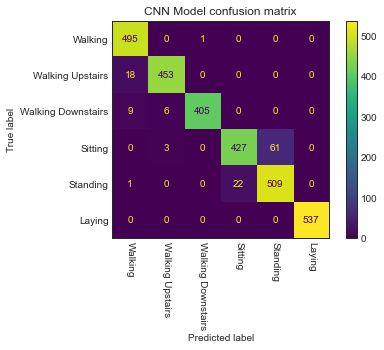

In [303]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 24))
cm = confusion_matrix(np.array(gt), np.array(pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(activity.values()))
disp.plot()
plt.title("CNN Model confusion matrix")
plt.xticks(rotation=270)
plt.savefig('CNN Model CM', dpi = 300)

In [178]:
torch.save(net, 'teacher_model.pth.tar')

## What's Next

We reached a pretty high accuracy of 95.9% on the test set. 

However, when using CNNs for edge AI prediction tasks, for example, deploying models on resource-constrained devices like smartphones, we may have several concerns:

- **Computational Resources**: CNNs can be computationally intensive, especially if the model is large or deep. Edge devices often have limited computational resources (CPU, memory, and power), which may not be sufficient to run complex CNN models efficiently.
- **Memory Footprint**: CNN models can have a significant memory footprint due to the large number of parameters they contain. This can be problematic for edge devices with limited memory capacity.
- **Inference Speed**: Real-time inference on edge devices may require fast prediction times, but complex CNN architectures may not meet the latency requirements of certain applications.
- **Model Size**: The size of CNN models can be large, making it challenging to deploy them on edge devices with limited storage capacity or bandwidth constraints.

With PyTorch, we can use the profiler to project memory usage of the CNN model and inference time to understand the bottlenecks. We'll fine tune these metrics by leveraging some model compression techniques to be suitable for edge computing as the next step.

In [227]:
# As seen in the results the model inference time can be as long as 510 ms!
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = net(data)
            _, pre = torch.max(out, 1)
            break
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

STAGE:2024-06-01 14:51:34 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(4799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        15.45%     510.606ms        99.98%        3.304s        3.304s     146.25 Mb     -73.71 Mb             1  
                                            aten::empty         0.06%       1.907ms         0.06%       1.907ms      41.457us     144.03 Mb     144.03 Mb            46  
                                           aten::conv2d         0.02%     601.000us         6.58%     217.370ms      54.343ms      72.00 Mb           

STAGE:2024-06-01 14:51:38 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [258]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = net(data)
                _, pre = torch.max(out, 1)
            break
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-06-01 20:56:42 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(22414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        14.90%     705.694ms        99.99%        4.735s        4.735s             1                                                                                []  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        76.83%        3.639s        76.84%       

STAGE:2024-06-01 20:56:47 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


## Knowledge Distillation

For model compression, we transfer the knowledge from the teacher model,
a complex CNN architecture, to a smaller, shallower student model. The shallow neural network use
fewer layers and parameters than the teach model, making it computationally efficient and faster to
train and run, which is beneficial for deployment on resource-constrained devices. In our study, we
designed a simple feedforward neural network and trained the shallower network with Knowledge
Distillation (KD) loss, which is a combination of the Kullback-Leibler(KL)-Divergence loss and the
regular Cross Entropy loss.

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyNN(nn.Module):
    """
    Implementation of a Shallow model

    :param img_size (int): Dimension of input image
    :param hidden_size (int): Hidden layer dimension
    :param num_classes (int): Number of classes for classification
    """

    def __init__(self, size=128, hidden_size=128, num_classes=6, num_channels=9):
        super(TinyNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.size = size
        self.num_channels = num_channels

        self.fc1 = nn.Linear(self.size * self.num_channels, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)

        return out

In [217]:
from torch.autograd import Variable


class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)
    
    
def loss_fn_kd(outputs, labels, teacher_outputs):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """
    alpha = 0.9
    T = 20
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss


def accuracy(outputs, labels):
    """
    Compute the accuracy, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) output of the model
        labels: (np.ndarray) [0, 1, ..., num_classes-1]

    Returns: (float) accuracy in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

def count_parameters_in_MB(model):
    return sum(np.prod(v.size()) for name, v in model.named_parameters())/1e6

def count_parameters_in_KB(model):
    return sum(np.prod(v.size()) for name, v in model.named_parameters())/1e3

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}


def train_kd(model, teacher_model, optimizer, loss_fn_kd, dataloader, metrics):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn_kd: 
        dataloader: 
        metrics: (dict) 
    """

    # set model to training mode
    model.train()
    teacher_model.eval()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = RunningAverage()

    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output, fetch teacher output, and compute KD loss
            output_batch = model(train_batch)

            # get one batch output from teacher_outputs list

            with torch.no_grad():
                output_teacher_batch = teacher_model(train_batch)

            loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            # Evaluate summaries only once in a while
            if i % 100 == 0:
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.numpy()
                labels_batch = labels_batch.data.numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                #print(loss.item())
                summary_batch['loss'] = loss.item()
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.item())

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    print("- Train metrics: " + metrics_string)
    
    
def evaluate_kd(model, dataloader, metrics):
    """Evaluate the model on `num_steps` batches.

    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []

    # compute metrics over the dataset
    for i, (data_batch, labels_batch) in enumerate(dataloader):

        # fetch the next evaluation batch
        data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)
        
        # compute model output
        output_batch = model(data_batch)

        # loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, params)
        loss = 0.0  #force validation loss to zero to reduce computation time

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output_batch = output_batch.data.numpy()
        labels_batch = labels_batch.data.numpy()

        # compute all metrics on this batch
        summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                         for metric in metrics}
        # summary_batch['loss'] = loss.data[0]
        summary_batch['loss'] = loss
        summ.append(summary_batch)

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    print("- Eval metrics : " + metrics_string)
    return metrics_mean

In [181]:
from torch.optim.lr_scheduler import StepLR
import json


NUM_EPOCHS_KD = 20

def save_dict_to_json(d, json_path):
    """Saves dict of floats in json file

    Args:
        d: (dict) of float-castable values (np.float, int, float, etc.)
        json_path: (string) path to json file
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)


def train_and_evaluate_kd(model, teacher_model, train_dataloader, val_dataloader, optimizer,
                       loss_fn_kd, metrics):
    """Train the model and evaluate every epoch.

    Args:
        model: (torch.nn.Module) the neural network
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) - file to restore (without its extension .pth.tar)
    """

    best_val_acc = 0.0

    # learning rate schedulers for different models:
    scheduler = StepLR(optimizer, step_size=100, gamma=0.2) 

    for epoch in range(NUM_EPOCHS_KD):

        scheduler.step()

        # Run one epoch
        print("Epoch {}/{}".format(epoch + 1, NUM_EPOCHS_KD))

        # compute number of batches in one epoch (one full pass over the training set)
        train_kd(model, teacher_model, optimizer, loss_fn_kd, train_dataloader,
                 metrics)

        # Evaluate for one epoch on validation set
        val_metrics = evaluate_kd(model, val_dataloader, metrics)

        val_acc = val_metrics['accuracy']
        is_best = val_acc>=best_val_acc
        print(is_best)

        # Save weights
        torch.save({'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optim_dict': optimizer.state_dict()},
                     'student_model.pth.tar')

        # If best_eval, best_save_path
        if is_best:
            print("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
            best_json_path = "metrics_val_best_weights.json"
            save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path =  "metrics_val_last_weights.json"
        save_dict_to_json(val_metrics, last_json_path)
        
    print('Teacher param size = %fMB', count_parameters_in_MB(teacher_model))
    print('Student param size = %fMB', count_parameters_in_MB(model))

In [184]:
# Train the Student Model with Knowledge Distillation
model = TinyNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
teacher_model = torch.load('teacher_model.pth.tar')
train_dl = train_loader
test_dl = test_loader


train_and_evaluate_kd(model, teacher_model, train_dl, test_dl, optimizer, loss_fn_kd, metrics)

Epoch 1/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(39783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:14<00:00,  3.88it/s, loss=2.166]

- Train metrics: accuracy: 0.195 ; loss: 2.840



python(39996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.575 ; loss: 0.000
True
- Found new best accuracy
Epoch 2/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(40134) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:16<00:00,  3.49it/s, loss=1.192]

- Train metrics: accuracy: 0.562 ; loss: 1.687



python(40546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.697 ; loss: 0.000
True
- Found new best accuracy
Epoch 3/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(40661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:25<00:00,  2.29it/s, loss=0.717]

- Train metrics: accuracy: 0.742 ; loss: 0.953



python(40948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.781 ; loss: 0.000
True
- Found new best accuracy
Epoch 4/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(41018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:23<00:00,  2.45it/s, loss=0.490]

- Train metrics: accuracy: 0.906 ; loss: 0.513



python(41314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.816 ; loss: 0.000
True
- Found new best accuracy
Epoch 5/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(41371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41373) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.94it/s, loss=0.367]

- Train metrics: accuracy: 0.906 ; loss: 0.404



python(41793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.835 ; loss: 0.000
True
- Found new best accuracy
Epoch 6/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(41870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:20<00:00,  2.86it/s, loss=0.295]

- Train metrics: accuracy: 0.945 ; loss: 0.311



python(42253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.839 ; loss: 0.000
True
- Found new best accuracy
Epoch 7/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(42404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.96it/s, loss=0.253]

- Train metrics: accuracy: 0.953 ; loss: 0.257



python(42851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.855 ; loss: 0.000
True
- Found new best accuracy
Epoch 8/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(42937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.39it/s, loss=0.229]

- Train metrics: accuracy: 0.930 ; loss: 0.252



python(43226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.874 ; loss: 0.000
True
- Found new best accuracy
Epoch 9/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(43335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.38it/s, loss=0.208]

- Train metrics: accuracy: 0.938 ; loss: 0.202



python(43584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.871 ; loss: 0.000
False
Epoch 10/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(43639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.23it/s, loss=0.193]

- Train metrics: accuracy: 0.938 ; loss: 0.230



python(43869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.878 ; loss: 0.000
True
- Found new best accuracy
Epoch 11/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(43934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.24it/s, loss=0.182]

- Train metrics: accuracy: 0.977 ; loss: 0.189



python(44295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.864 ; loss: 0.000
False
Epoch 12/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(44359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:18<00:00,  3.19it/s, loss=0.170]

- Train metrics: accuracy: 0.953 ; loss: 0.176



python(44768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.868 ; loss: 0.000
False
Epoch 13/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(44845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(44848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:21<00:00,  2.66it/s, loss=0.162]

- Train metrics: accuracy: 0.953 ; loss: 0.153



python(45297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.883 ; loss: 0.000
True
- Found new best accuracy
Epoch 14/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(45462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.92it/s, loss=0.153]

- Train metrics: accuracy: 0.938 ; loss: 0.159



python(45869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.883 ; loss: 0.000
False
Epoch 15/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(45924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.99it/s, loss=0.149]

- Train metrics: accuracy: 0.953 ; loss: 0.146



python(46163) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46164) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.886 ; loss: 0.000
True
- Found new best accuracy
Epoch 16/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(46222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:21<00:00,  2.72it/s, loss=0.142]

- Train metrics: accuracy: 0.977 ; loss: 0.144



python(46570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.886 ; loss: 0.000
True
- Found new best accuracy
Epoch 17/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(46649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.93it/s, loss=0.136]

- Train metrics: accuracy: 0.953 ; loss: 0.136



python(47067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.873 ; loss: 0.000
False
Epoch 18/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(47129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:20<00:00,  2.88it/s, loss=0.132]

- Train metrics: accuracy: 0.953 ; loss: 0.128



python(47479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.890 ; loss: 0.000
True
- Found new best accuracy
Epoch 19/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(47594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:18<00:00,  3.15it/s, loss=0.128]

- Train metrics: accuracy: 0.969 ; loss: 0.122



python(47879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.881 ; loss: 0.000
False
Epoch 20/20


  0%|                                                                            | 0/58 [00:00<?, ?it/s]python(47957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.23it/s, loss=0.124]

- Train metrics: accuracy: 0.961 ; loss: 0.112



python(48275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48276) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


- Eval metrics : accuracy: 0.894 ; loss: 0.000
True
- Found new best accuracy
Teacher param size = %fMB 0.546822
Student param size = %fMB 0.16487


In [299]:
# Student Model Evaluation Metrics
model.eval()
cor = 0
pred = []
gt = []
for data, label in test_loader:
    data, label = data, label
    with autocast():
        out = model(data)
    _, pre = torch.max(out, 1)
    
    pred += pre.tolist()
    gt += label.tolist()
    cor += (pre == label).sum()

acc = cor.item()/len(Y_test)
print('val-acc: %f' % (acc))


python(18066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/zliu/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


val-acc: 0.889718


In [194]:
print("F1(macro): ", round(f1_score(gt, pred, average='macro'), 4))

F1(macro):  0.8881


<Figure size 1440x1728 with 0 Axes>

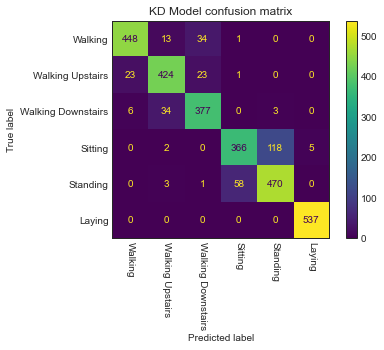

In [301]:
# Student Model Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 24))
cm = confusion_matrix(np.array(gt), np.array(pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(activity.values()))
disp.plot()
plt.title("KD Model confusion matrix")
plt.xticks(rotation=270)
plt.savefig('KD Model CM', dpi = 300)

### Quantization

Now let's do some quantization post-training with torch.ao.quantization.quantize_dynamic to reduce memory footprint and speed up inference.

In [206]:
# quantization with the initial CNN
net_int8 = torch.ao.quantization.quantize_dynamic(
    net,  # the original model
    {nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [208]:
net_int8.eval()
cor = 0
pred = []
gt = []
for data, label in test_loader:
    data, label = data, label
    with autocast():
        out = net_int8(data)
    _, pre = torch.max(out, 1)
    
    pred += pre.tolist()
    gt += label.tolist()
    cor += (pre == label).sum()

acc = cor.item()/len(Y_test)
print('val-acc: %f' % (acc))
print("F1(macro): ", round(f1_score(gt, pred, average='macro'), 4))

python(63432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/zliu/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


val-acc: 0.958941
F1(macro):  0.9593


In [211]:
# quantization with the KD Model
model_int8 = torch.ao.quantization.quantize_dynamic(
    model,  # the original model
    {nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [214]:
model_int8.eval()
cor = 0
pred = []
gt = []
for data, label in test_loader:
    data, label = data, label
    with autocast():
        out = model_int8(data)
    _, pre = torch.max(out, 1)
    
    pred += pre.tolist()
    gt += label.tolist()
    cor += (pre == label).sum()

acc = cor.item()/len(Y_test)
print('val-acc: %f' % (acc))
print("F1(macro): ", round(f1_score(gt, pred, average='macro'), 4))

python(70642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/zliu/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


val-acc: 0.889718
F1(macro):  0.8881


### How does the models perform on edge devices?

We use the profiler to compare metrics such as CPU time for model inference, memory consumption, and inference speed for the models we built.

In [244]:
# model inference speed for the original CNN model

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = net(data)
            _, pre = torch.max(out, 1)
            break

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-06-01 20:37:30 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(96931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        12.70%     693.526ms        99.84%        5.452s        5.452s             1  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        81.33%        4.441s        81.34%        4.442s        4.442s             1  
                                           aten::conv2d         0.00%     122.000us         3.94%     214.978ms      53.745ms             4  
                                      aten::convolution         0.02%       1.278ms         3.93%     214.856ms      53.714ms             4  
      

STAGE:2024-06-01 20:37:36 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [252]:
# memory footprint for the original CNN model

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    for data, label in test_loader:
        data, label = data, label
        with autocast():
            out = net(data)
        _, pre = torch.max(out, 1)
        break

print(prof.key_averages().table(sort_by="cpu_memory_usage"))

STAGE:2024-06-01 20:50:10 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(14069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.07%       5.159ms         0.07%       5.159ms     122.833us     144.03 Mb     144.03 Mb            42  
                                           aten::conv2d         0.00%     196.000us         6.60%     476.751ms     119.188ms      72.00 Mb           0 b             4  
                                      aten::convolution         0.01%     904.000us         6.60%     476.555ms     119.139ms      72.00 Mb           

STAGE:2024-06-01 20:50:18 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [245]:
# model inference speed for the student model

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = model(data)
            _, pre = torch.max(out, 1)
            break

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-06-01 20:37:57 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(97567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        24.96%     396.274ms        99.92%        1.587s        1.587s             1  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        73.14%        1.161s        73.15%        1.161s        1.161s             1  
                                           aten::linear         0.00%      61.000us         1.50%      23.793ms       7.931ms             3  
                                            aten::addmm         1.25%      19.918ms         1.35%      21.503ms       7.168ms             3  
      

STAGE:2024-06-01 20:37:59 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [253]:
# memory footprint for the student model

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    for data, label in test_loader:
        data, label = data, label
        with autocast():
            out = model(data)
        _, pre = torch.max(out, 1)
        break

print(prof.key_averages().table(sort_by="cpu_memory_usage"))

STAGE:2024-06-01 20:51:11 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(15061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        99.80%        5.216s        99.81%        5.216s        5.216s     577.12 Kb     576.85 Kb             1  
                                           aten::linear         0.00%      35.000us         0.11%       5.819ms       1.940ms     131.00 Kb           0 b             3  
                                            aten::addmm         0.10%       5.315ms         0.10%       5.446ms       1.815ms     131.00 Kb     131.00

STAGE:2024-06-01 20:51:17 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [248]:
# model inference speed for the CNN model with quantization

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = net_int8(data)
            _, pre = torch.max(out, 1)
            break

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-06-01 20:39:51 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        18.95%     449.672ms       100.00%        2.373s        2.373s             1  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        72.12%        1.712s        72.12%        1.712s        1.712s             1  
                                           aten::conv2d         0.00%      22.000us         6.77%     160.767ms      40.192ms             4  
                                      aten::convolution         0.01%     170.000us         6.77%     160.745ms      40.186ms             4  
      

STAGE:2024-06-01 20:39:53 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [255]:
# memory footprint for the CNN model with quantization

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    for data, label in test_loader:
        data, label = data, label
        with autocast():
            out = net_int8(data)
        _, pre = torch.max(out, 1)
        break

print(prof.key_averages().table(sort_by="cpu_memory_usage"))

STAGE:2024-06-01 20:53:46 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(19316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.05%       1.421ms         0.05%       1.421ms      33.833us     144.04 Mb     144.04 Mb            42  
                                       aten::empty_like         0.00%      21.000us         0.00%      59.000us      11.800us      72.00 Mb           0 b             5  
                                           aten::conv2d         0.00%      29.000us         5.17%     150.024ms      37.506ms      72.00 Mb           

STAGE:2024-06-01 20:53:50 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [250]:
# model inference speed for the student model with quantization

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for data, label in test_loader:
            data, label = data, label
            with autocast():
                out = model_int8(data)
            _, pre = torch.max(out, 1)
            break

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-06-01 20:40:32 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(1238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        19.84%     352.247ms       100.00%        1.776s        1.776s             1  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        80.10%        1.422s        80.10%        1.422s        1.422s             1  
                              quantized::linear_dynamic         0.04%     668.000us         0.04%     706.000us     235.333us             3  
                                         aten::randperm         0.01%     131.000us         0.02%     395.000us     197.500us             2  
      

STAGE:2024-06-01 20:40:34 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [257]:
# memory footprint for the student model with quantization

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    for data, label in test_loader:
        data, label = data, label
        with autocast():
            out = model_int8(data)
        _, pre = torch.max(out, 1)
        break

print(prof.key_averages().table(sort_by="cpu_memory_usage"))

STAGE:2024-06-01 20:55:41 89423:25323328 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
python(21355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        99.91%        3.180s        99.92%        3.180s        3.180s       2.25 Mb       2.25 Mb             1  
                                            aten::empty         0.01%     475.000us         0.01%     475.000us      25.000us     285.32 Kb     285.32 Kb            19  
                              quantized::linear_dynamic         0.05%       1.654ms         0.05%       1.714ms     571.333us     131.00 Kb    -131.00

STAGE:2024-06-01 20:55:45 89423:25323328 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [295]:
# check model size on disk for the original CNN model

import os
torch.save(net.state_dict(), 'net_state_dict.pth')
state_dict = torch.load('net_state_dict.pth')

# Calculate the size of the state dictionary in bytes
#total_size = sum(param.numel() * param.element_size() for param in state_dict.values())
#print(f'Total size of state_dict: {total_size} bytes')

# Alternatively, check file size directly
file_size = os.path.getsize('net_state_dict.pth')/1e6
print(f'File size of state_dict: {file_size} Mb')

File size of state_dict: 2.204075 Mb


In [294]:
# check model size on disk for the student model
torch.save(model.state_dict(), 'model_state_dict.pth')
state_dict = torch.load('model_state_dict.pth')

# Calculate the size of the state dictionary in bytes
#total_size = sum(param.numel() * param.element_size() for param in state_dict.values())
#print(f'Total size of state_dict: {total_size} bytes')

# Alternatively, check file size directly
file_size = os.path.getsize('model_state_dict.pth')/1e6
print(f'File size of state_dict: {file_size} Mb')

File size of state_dict: 0.661663 Mb


In [296]:
# check model size on disk for the original CNN model with quantization
torch.save(net_int8.state_dict(), 'net_int8_state_dict.pth')
state_dict = torch.load('net_int8_state_dict.pth')

# Calculate the size of the state dictionary in bytes
#total_size = sum(param.numel() * param.element_size() for param in state_dict.values())
#print(f'Total size of state_dict: {total_size} bytes')

# Alternatively, check file size directly
file_size = os.path.getsize('net_int8_state_dict.pth')/1e6
print(f'File size of state_dict: {file_size} Mb')


File size of state_dict: 2.122141 Mb


In [293]:
# check model size on disk for the student model with quantization
torch.save(model_int8.state_dict(), 'quantized_model_state_dict.pth')
state_dict = torch.load('quantized_model_state_dict.pth')

#  check file size directly
file_size = os.path.getsize('quantized_model_state_dict.pth')/1e6
print(f'File size of state_dict: {file_size} Mb')

File size of state_dict: 0.170059 Mb
